## 2023638 | Anton Dementyev | Lab Assignment 2

In [311]:
from sklearn import datasets
import numpy as np
import math
import matplotlib.pyplot as plt
import pprint

In [312]:
iris = datasets.load_iris()

In [313]:
print('Description' + '\n')
print(f'Dims: X - {iris.data.shape}, Y - {iris.target.shape}')
print('Samples:', iris.data[0], iris.target[0])
num_categories = len(np.unique(iris.target))
print(f'{num_categories} unique categories are present')
num_features = iris.data.shape[1]
print(f'{num_features} features are present in each sample')

Description

Dims: X - (150, 4), Y - (150,)
Samples: [5.1 3.5 1.4 0.2] 0
3 unique categories are present
4 features are present in each sample


### Cross Validation

In [314]:
# Splitting the data right away. For each of the 3 categories, the first 40 go to training data, the remaining 10 - to testing.
X_train, Y_train, X_test, Y_test = [], [], [], []
for i in range(len(iris.data)):
    if i % 40 >= 0 and i % 50 < 10:
        X_test.append(iris.data[i])
        Y_test.append(iris.target[i])
    else:
        X_train.append(iris.data[i])
        Y_train.append(iris.target[i])
print(f'lengths: {len(X_train)} - train, {len(X_test)} - test')

lengths: 120 - train, 30 - test


### Likelihood

In [315]:
# accumulating means and standard deviations
obj = {}
for i in range(num_categories):
    obj[i] = {'means': [], 'stds': []}
cat_length = int(len(X_train) / num_categories)

# calculating means and standard deviations for each category and for each sample feature
for k in range(num_categories):
    slc = X_train[int(k * cat_length) : int((k+1) * cat_length)]
    for i in range(num_features):
        # mean
        mean = sum([x[i] for x in slc]) / cat_length
        obj[k]['means'].append(mean) 
    for i in range(num_features):
        mean = obj[k]['means'][i]
        # std
        obj[k]['stds'].append(math.sqrt(sum([(x[i] - mean) ** 2 for x in slc]) / cat_length))
    
pprint.pprint(obj)

{0: {'means': [5.0425, 3.4574999999999996, 1.4649999999999994, 0.2525],
     'stds': [0.35558929961403507,
              0.38787079034131977,
              0.18513508581573615,
              0.10951598056904757]},
 1: {'means': [5.894999999999999,
               2.7449999999999997,
               4.2325,
               1.3124999999999998],
     'stds': [0.4460661385938188,
              0.3024483426967323,
              0.46172908723622785,
              0.20147890708458788]},
 2: {'means': [6.592500000000001,
               2.982499999999999,
               5.497499999999999,
               2.0224999999999995],
     'stds': [0.5913490931759346,
              0.3185023547793643,
              0.5265394097311237,
              0.27063582541858716]}}


In [316]:
# calculating density
def likelihood(x, feature, c):
    mean = obj[c]['means'][feature]
    std = obj[c]['stds'][feature]
    return 1 / (math.sqrt(2 * math.pi) * std) * math.exp(-0.5*(((x[feature] - mean) ** 2) / (std ** 2)))

# likelihood for each feature of a category: P(X|C(i))
def pxc(x, c):
    mult = 1
    for feature in range(len(x)):
        mult = mult * likelihood(x, feature, c)
    return mult

In [317]:
# testing, values above 1 are fine, since this is a density func
print(pxc(X_train[22], 0))
print(pxc(X_train[62], 1))
print(pxc(X_train[102], 2))

0.7758643195070464
1.28827472050413
0.6010720427395932


### Priori

In [318]:
# Since all categories are equal, the category priori probability is the same
priori_c = 1 / num_categories

In [319]:
print(priori_c)

0.3333333333333333


### Posterior

In [320]:
px = num_categories / len(X_train)

In [321]:
print(px)

0.025


In [322]:
# Finding the max across all categories to classify the sample x
def posterior(x):
    mx = (0, -1)
    for c in range(num_categories):
        inter = pxc(x, c) * priori_c
        if inter > mx[0]:
            mx = (inter, c)
    return (mx[0] / px, mx[1])

### Performance Evaluation

In [323]:
# Simple evalutation function
def evaluate(X_test, Y_test):
    correct = 0
    for x, y in zip(X_test, Y_test):
        if posterior(x)[1] == y:
            correct = correct + 1
    return correct / len(X_test)

In [324]:
result = evaluate(X_test, Y_test)
print(f'The classifier has reached {"{:.2f}".format(result*100)}% on the testing set')

The classifier has reached 93.33% on the testing set


### Challenging Task

In [325]:
# getting a category based on the prior probabily
category = np.random.choice([i for i in range(num_categories)], 1, p=[priori_c for i in range(num_categories)])[0]
# sampling @num_samples@ from a normal distribution, accounting the acquired prior distribution stats
num_samples = cat_length
sp = np.array([])
for feature in range(num_features):
    feature_d = np.array([[x] for x in np.random.normal(loc=obj[category]['means'][feature], scale=obj[category]['stds'][feature], size=num_samples)])
    if feature == 0:
        sp = feature_d
    else:
        sp = np.hstack((sp, feature_d))

In [326]:
eval_sampled = evaluate(sp, [category for x in sp])
print(f'The classifier has reached {"{:.2f}".format(eval_sampled*100)}% on the sampled set')

The classifier has reached 100.00% on the sampled set


In [327]:
iris_names = {
    0: 'Iris setosa',
    1: 'Iris virginica',
    2: 'Iris versicolor'
}

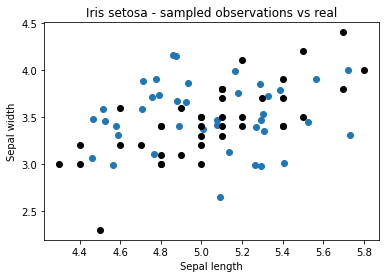

In [328]:
plt.title(f'{iris_names[category]} - sampled observations vs real')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.scatter(sp[:,0], sp[:,1])
real = np.array(X_train[int(category * num_samples) : int((category+1) * num_samples)])

plt.scatter(real[:,0], real[:,1], color='black')